In [1]:
%matplotlib inline
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
from scipy.signal import convolve2d
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd

np.set_printoptions(precision=3, suppress=True)

import time

In [445]:
N = 50
nCell = 1
nNeighbors = 8
nSpecies = 7

initDistribution = np.random.uniform(size = nSpecies*N*N)

initField = nCell * initDistribution.reshape(nSpecies,N,N)
growthRates = np.array(nSpecies*[0.2]) 

deathRates = np.array(nSpecies*[0.6])
boost = 0
boostRates = np.eye(nSpecies)
for a in range(nSpecies-1):
    boostRates[a, a+1] = boost
boostRates[nSpecies-1,0] = boost

boostRates

    
def getDominantSpeies(field):
    return np.argsort(field,axis = 0, )[-1,:,:]

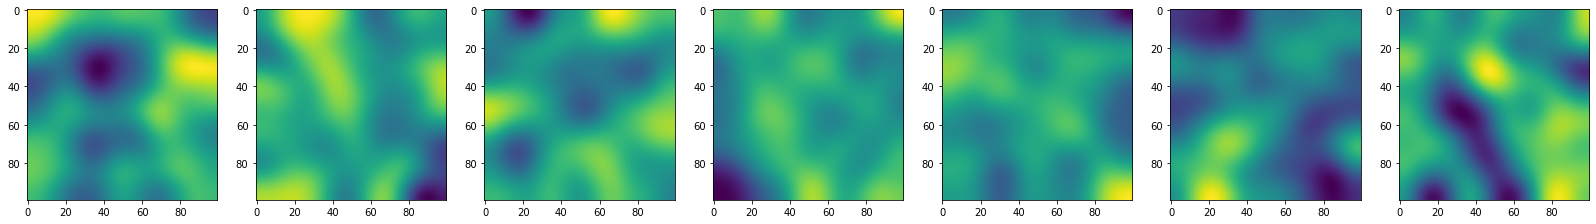

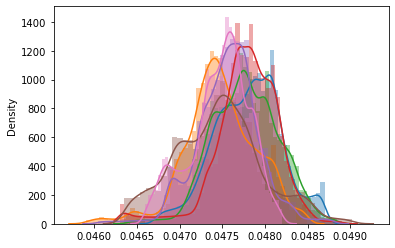

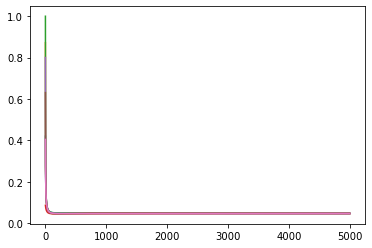

In [50]:
nSteps = 5000

fields = [initField]

for n in range(nSteps):
    field = fields[-1]
    newField = np.zeros((nSpecies,N,N))
    
    filt = np.ones((3,3)) / nNeighbors # sum up all neighbors of the same species
    for i in range(nSpecies):
        newField[i] = convolve2d(field[i,:,:], filt, mode = "same") 
        
    growth = np.einsum('ij,jkl->jkl', 
                       boostRates, 
                       newField / newField.sum(axis=0) # growth boost should be normalized
                      ) * growthRates[:,None, None] 
    death = deathRates[:,None,None]
   # print(np.sum(field*growth), np.sum(field*death))
    newField = field + field * growth - field**2 * death
   # newField /= np.sum(field, axis = 0)
    np.place(newField, newField < 0, 0)
    fields.append(newField)
    
    
%matplotlib inline

fig, ax = plt.subplots(1,nSpecies, figsize = (4*nSpecies,4))
for i in range(nSpecies):
    ax[i].imshow(fields[-1][i])
plt.show()

for a in range(nSpecies):
    sns.distplot(fields[-1][a].flatten())   
plt.show()

for i in range(nSpecies):
    plt.plot([f[i,1,1] for f in fields])

In [51]:
fields[-1][0].sum()#[:,1,1]

478.01398236138067

<IPython.core.display.Javascript object>


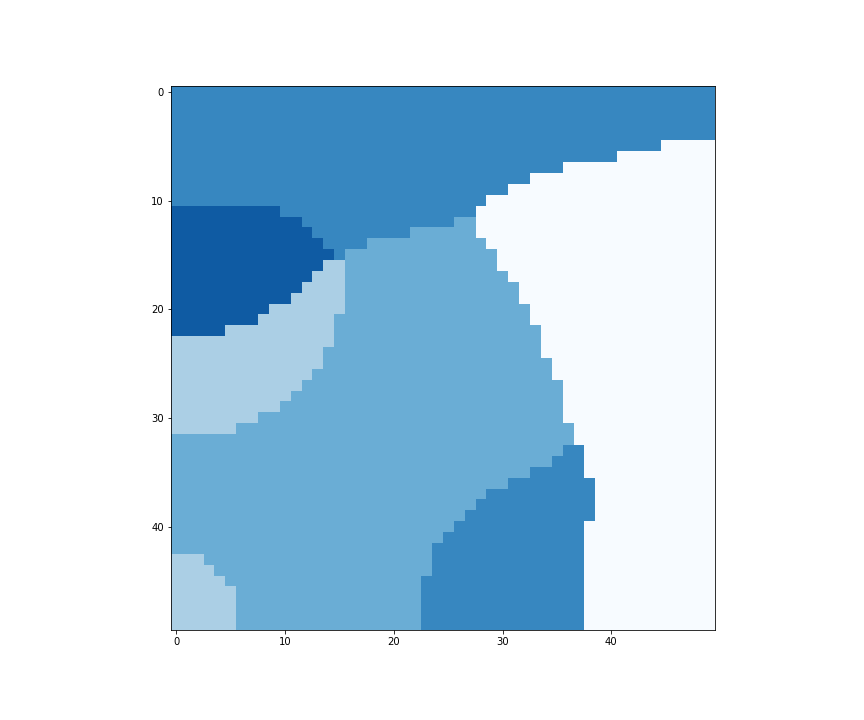

In [450]:
%matplotlib notebook

fig, ax = plt.subplots(figsize = (12,10))

im=plt.imshow(getDominantSpeies(initField),
             # interpolation='none', 
              interpolation='none', 
              cmap = "Blues")

field = initField
# initialization function: plot the background of each frame
def init():
    im.set_data(getDominantSpeies(field))
    return [im]

# animation function.  This is called sequentially
step = 1
def animate(i):
    global field
    newField = np.zeros((nSpecies,N,N))
    
    filt = np.ones((3,3)) / nNeighbors # sum up all neighbors of the same species
    for i in range(nSpecies):
        newField[i] = convolve2d(field[i,:,:], filt, mode = "same") 
        
    growth = np.einsum('ij,jkl->jkl', 
                       boostRates, 
                       newField / newField.sum(axis=0) # growth boost should be normalized
                      ) * growthRates[:,None, None] 
    death = deathRates[:,None,None]
   # print(np.sum(field*growth), np.sum(field*death))
    newField = field + field * growth - field**2 * death
   # newField /= np.sum(field, axis = 0)
    np.place(newField, newField < 0, 0)
    field = newField
    if i % step == 0:
        im.set_array(getDominantSpeies(field))
    return [im]

ani = FuncAnimation(fig, animate, frames=nSteps, interval=1, 
                    init_func=init, blit=True)
plt.show()

In [429]:
animate(1)

NameError: name 'field' is not defined

### hypercycles based off 
Boerlijst, Maarten C., and Paulien Hogeweg. "Spiral wave structure in pre-biotic evolution: hypercycles stable against parasites." Physica D: Nonlinear Phenomena 48.1 (1991): 17-28.

In [2]:
def north(i, j):
    j -= 1
    return i, pbc(j), 0, -1

def east(i, j):
    i += 1
    return pbc(i), j, 1, 0

def south(i, j):
    j += 1
    return i, pbc(j), 0, 1

def west(i, j):
    i -= 1
    return pbc(i), j, -1, 0

deltas = [[0,-1],[1,0],[0,1],[-1,0],]

directions = [north, east, south, west]

def pbc(x):
    global N
    if x >= N:
        return x - N 
    if x < 0:
        return x + N
    else: return x

In [3]:
N = 75

pDeath = 0.1
wDead = 5
wBoost = 100


nSpecies = 9
sMax = 6
speciesIdList = range(1, nSpecies + 1) # or have them from 0 to nSpecies to init with empty
speciesIds = np.arange(1, nSpecies+1, dtype = int)

In [4]:
%matplotlib inline

lattice = np.zeros((nSpecies+1,N,N), dtype = int)
initDistribution = np.random.choice(speciesIdList, size = N*N)
initLattice = initDistribution.reshape(N,N)
for s in range(1,nSpecies+1):
    lattice[s][initLattice == s] = 1



nSteps = 250

trs = []
cfs = []
frs = []
pops = []
boosts = []
for t in range(nSteps):    
    newLattice = np.zeros((nSpecies+1, N, N), dtype = int)
    latticeFlat = (lattice[1:, :, :] * speciesIds[:,None,None]).sum(axis = 0)
    totalReplications = 0
    crowdedFails = 0
    boosts = []
    for i in range(N):
        for j in range(N):

            s = latticeFlat[i, j] # the id of species in i, j
            
            if s == 0: continue # already dead

            # replication
            if np.random.uniform() >= pDeath:
                newLattice[s, i, j] = 1 # survived
                
                # try replicate into empty cells
                empty = np.array([
                    latticeFlat[north(i, j)[:2]] == 0,
                    latticeFlat[east (i, j)[:2]] == 0,
                    latticeFlat[south(i, j)[:2]] == 0,
                    latticeFlat[west (i, j)[:2]] == 0,
                ])
                
                if empty.sum() > 0:
                    
                    sPrev = s - 1 # boost comes from the previous species
                    if sPrev == 0: sPrev = nSpecies - 2 # correct booster idx for the first species
                    if sPrev > sMax: sPrev = sMax    
                    emptyDirectons = np.where(empty != 0)[0]
                    #randomEmpty = np.random.choice(emptyDirectons)
                    for randomEmpty in emptyDirectons:
                        iNew, jNew, dI, dJ = directions[randomEmpty](i, j)

                        nBoost = wBoost * np.sum([ # "any of the four neigbors"
                                lattice[sPrev, pbc(iNew + dJ), pbc(jNew + dI)],
                                lattice[sPrev, pbc(iNew - dJ), pbc(jNew - dI)],
                                lattice[sPrev, pbc(i + dJ), pbc(j + dI)],
                                lattice[sPrev, pbc(i - dJ), pbc(j - dI)]])
                                + npSum([lattice[s, pbc(iNew + dJ), pbc(jNew + dI)],
                                lattice[s, pbc(iNew - dJ), pbc(jNew - dI)],
                                lattice[s, pbc(i + dJ), pbc(j + dI)],
                                lattice[s, pbc(i - dJ), pbc(j - dI)],])
                        

                        newLattice[s][iNew, jNew] += nBoost # accumulate claims
                       # boosts.append(nBoost)
                else:
                    crowdedFails += 1
           # else:
           #     print("died")
    
    # resolve claims
    failedReplications = 0
    ps = []
    for i in range(N):
        for j in range(N):
            if latticeFlat[i,j] == 0:
                col = newLattice[1:,i,j] # examine species only
                if col.sum() == 0: # all dead, no claims
                #    print("all dead, no claims")
                    continue
                w = np.hstack([wDead, col])
                p = w / sum(w)
                ps.append(p[0] / sum(p[1:]))
                winningReplicator = np.random.choice(range(nSpecies+1), p = p)
                if winningReplicator == 0: # remain empty
                    newLattice[:,i,j] = 0
                    failedReplications += 1
                  #  print("dead won")
                    continue
                newLattice[:,i,j] = 0
                newLattice[winningReplicator,i,j] = 1        
                totalReplications += 1
    lattice = newLattice
    
    trs.append(totalReplications)
    cfs.append(crowdedFails)
    frs.append(failedReplications)
    pops.append(newLattice.sum())
    
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(latticeFlat)
    sns.histplot(ps, ax =ax[1])
    sns.histplot(boosts, ax =ax[2])
    ccc = Counter(latticeFlat.flatten())
    ccc2 = {}
    for s in range(nSpecies+1):
        if s in ccc:
            ccc2[s] = ccc[s]
        else:
            ccc2[s] = 0
    sns.barplot(data = pd.DataFrame(ccc2, 
                index = [0]),
                    order = range(nSpecies+1), ax = ax[3])
    plt.show()
    
    # diffusion            
#     for i in range(N):
#         for j in range(N):
#             if newLattice[i, j] == 0: continue
            
            
                
        

IndentationError: unexpected indent (3162512044.py, line 58)

In [165]:
pd.DataFrame(Counter(latticeFlat.flatten()), index = [0])

,4,6,3,2,5,9,7,1,8
0,1854,1861,1691,1848,1857,1801,1798,1868,1806


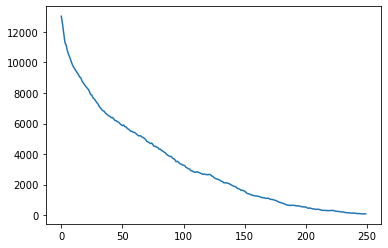

In [160]:
plt.plot(pops)

<IPython.core.display.Javascript object>


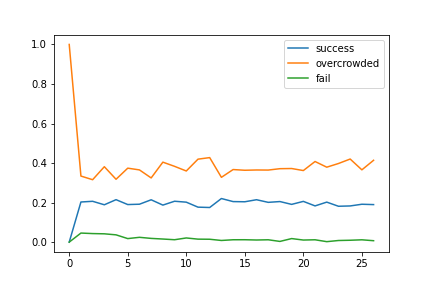

In [215]:
plt.plot([t/pp for t,pp in zip(trs,pops)], label = "success")
plt.plot([f/pp for f,pp in zip(cfs,pops)], label = "overcrowded")
plt.plot([f/pp for f,pp in zip(frs,pops)], label = "fail")
plt.legend()

In [ ]:
N**2 = 2 * np.pi * R**2

325.94932345220167

<IPython.core.display.Javascript object>


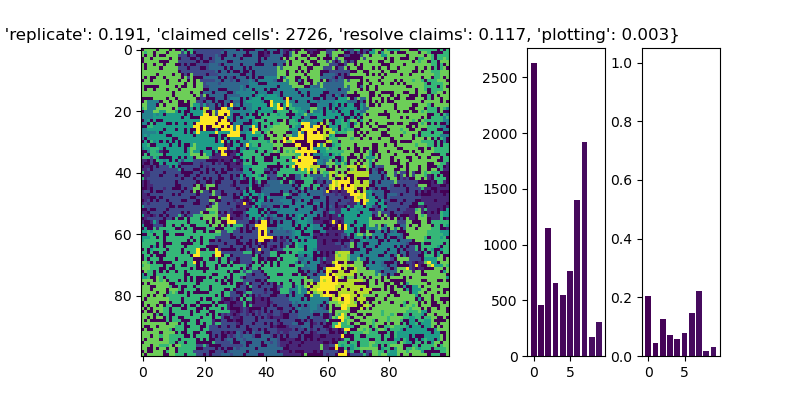

In [9]:
%matplotlib notebook
timerPresicion = 3

N = 100

pDeath = 0.3
wDead = 1
wRepl = 1
wBoost = 100


nSpecies = 9

speciesIds = np.arange(nSpecies+1, dtype = int)

lattice = np.zeros((nSpecies+1,N,N), dtype = int)
initDistribution = np.random.choice(speciesIds[1:], size = N*N)
initLattice = initDistribution.reshape(N,N)


Rsq = N**2/2/np.pi / 2
seedIs = []
seedJs = []
for i in range(N):
    for j in range(N):
        if (N/2 - i)**2 + (N/2 - j)**2 > Rsq:
            seedIs.append(i)
            seedJs.append(j)

initLattice[seedIs,seedJs] = 0 
newLattice = np.zeros((nSpecies+1, N, N), dtype = int) # init global


for s in range(1,nSpecies+1):
    lattice[s][initLattice == s] = 1

cmap = "viridis"
my_cmap = plt.get_cmap(cmap)
colors = my_cmap.colors[:nSpecies+1]


fig, ax = plt.subplots(1,3,figsize = (8,4),
                       dpi = 100,
    gridspec_kw=dict(width_ratios=[5, 1, 1], 
                     wspace=0.2)
                      )

im=ax[0].imshow(initLattice, 
                interpolation='none', 
              #cmap = "Blues"
              cmap = cmap
             )
im2=ax[1].bar(x = range(nSpecies + 1), height = [5]*(nSpecies+1), color = colors)
im3=ax[2].bar(x = range(nSpecies + 1), height = [1]*(nSpecies+1), color = colors)



def init():
    im1 = plt.imshow(np.zeros(N,N))
    im2 = plt.bar(x = range(nSpecies + 1), height = [5]*(nSpecies+1), color = colors)
    return [im1, im2]

def animate(i):
    global lattice
    global latticeFlat
    timers = {}
    start = time.time()
    newLattice = np.zeros((nSpecies+1, N, N), dtype = int)
    latticeFlat = (lattice * speciesIds[:,None,None]).sum(axis = 0)
    end = time.time()
    timers["init"] = round(end - start, timerPresicion)
    
    
    lattceFlatAliveIds = np.where(latticeFlat != 0)
    r = np.random.random(size = (N, N))
    newLatticeFlat = latticeFlat.copy()
    newLatticeFlat[r < pDeath] = 0
    for s in range(1, nSpecies+1):
        newLattice[s, newLatticeFlat == s] = 1
        
    totalReplications = 0
    crowdedFails = 0    
    
    ############################
    # get claims
    ############################
    start = time.time()
    for i,j in zip(*lattceFlatAliveIds):
        s = latticeFlat[i, j] # the id of species in i, j
#         if np.random.uniform() < pDeath:
#             newLattice[:, i, j] = 0 # died
#         else:
#             newLattice[s, i, j] = 1 # alive

        # get claims for empty neighbors
        empty = np.array([
            latticeFlat[north(i, j)[:2]] == 0,
            latticeFlat[east (i, j)[:2]] == 0,
            latticeFlat[south(i, j)[:2]] == 0,
            latticeFlat[west (i, j)[:2]] == 0,
        ])

        if empty.sum() > 0:

            sPrev = s - 1 # boost comes from the previous species
            if sPrev == 0: sPrev = nSpecies # correct booster idx for the first species

            emptyDirectons = np.where(empty != 0)[0]
            #randomEmpty = np.random.choice(emptyDirectons) # allow at most one replication
            for randomEmpty in emptyDirectons: # replicate in all directions
                iNew, jNew, dI, dJ = directions[randomEmpty](i, j)

                boost = wBoost * np.sum([ # "any of the four neigbors"
                        lattice[sPrev, pbc(iNew + dJ), pbc(jNew + dI)],
                        lattice[sPrev, pbc(iNew - dJ), pbc(jNew - dI)],
                        lattice[sPrev, pbc(i + dJ), pbc(j + dI)],
                        lattice[sPrev, pbc(i - dJ), pbc(j - dI)]])
                newLattice[s][iNew, jNew] += wRepl + boost # accumulate claims
        else:
            crowdedFails += 1

    end = time.time()
    timers["replicate"] = round(end - start, timerPresicion)
    
    
    ############################
    # resolve claims
    ############################
    start = time.time()
    
    failedReplications = 0
    ps = []

   # claimIds = [z for z in zip(*np.where(newLattice.sum(axis = 0) != 0))]
    
    lattceFlatDeadIds = np.where((latticeFlat == 0) & (newLattice.sum(axis = 0) != 0))
   # lattceFlatDeadIds = [z for z in zip(*lattceFlatDeadIds) if z in claimIds]
    timers["claimed cells"] = len(lattceFlatDeadIds[0])
    for i,j in zip(*lattceFlatDeadIds):
        col = newLattice[1:,i,j] # examine species only
            
        claims = np.hstack([wDead, col])
        
        p = claims / sum(claims)
        ps.append(p) # for stats
        
        winningReplicator = np.random.choice(range(nSpecies+1), p = p)
        
        newLattice[:,i,j] = 0  #    all lose
        
        if winningReplicator == 0: # remain empty
            failedReplications += 1
        else:
            newLattice[winningReplicator,i,j] = 1 # winner 
            totalReplications += 1
                
    lattice = newLattice
    latticeFlat = (lattice * speciesIds[:,None,None]).sum(axis = 0)

    end = time.time()
    timers["resolve claims"] = round(end - start, timerPresicion)
    
    
    
    ############################
    # plotting
    ############################
    start = time.time()

    im.set_array(latticeFlat)
    
    ccc = Counter(latticeFlat.flatten())
    for s in range(nSpecies+1):
        if not s in ccc:
            ccc[s] = 0
        
    vvv = [v for k,v in sorted([(k,v) for k,v in ccc.items()])]
    for rect, h in zip(im2, vvv):
        rect.set_height(h)
    ax[1].set_ylim(0, 1.05*max(vvv))
    meanPs = np.mean(ps, axis = 0)
    for rect, p in zip(im3, meanPs):
        rect.set_height(p)
    
    end = time.time()
    timers["plotting"] = round(end - start, timerPresicion)    
    ax[0].set_title(timers)

    return [im,im2,im3]

ani = FuncAnimation(fig, animate, frames=20000, interval=15, save_count = 5,
                    cache_frame_data = True,
                    blit=False
                   )
#plt.show()

In [6]:
latticeFlat.copy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [32]:
    t = Timer()
    
    t.start()
    newLattice = np.zeros((nSpecies+1, N, N), dtype = int)
    latticeFlat = (lattice * speciesIds[:,None,None]).sum(axis = 0)
    t.stop()

NameError: name 'Timer' is not defined

In [8]:
animate(1)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 100